# <center>Bad Bank Behavior<br>Analyzing Bank Mortgage during the 2007 Housing Bubble</center>  

<center>Michael Siebel</center>
<center>August 2020</center>
<br>

## <center>Model Selection Script</center>

# Purpose  
<br>

> Runs a relative importance analysis called permutation importance to determine the most important features in each of the algorithms that will be modelled subsequently.  Features with low importance may be subject for removal from the model selection.

> The permutation importance of a feature is calculated as follows. First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. Next, a feature column from the validation set is permuted and the metric is evaluated again. The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

***

# Load Functions

In [60]:
%run Functions.ipynb
pd.set_option("display.max_columns", 200)
pd.set_option('display.max_rows', 200)

file_to_open = open('..\Data\df.pkl', 'rb') 
df  = pickle.load(file_to_open) 
file_to_open.close()

# Drop mergeID column
df = df.drop(labels='Loan ID', axis=1)

# Convert Inf values to NA
pd.set_option('mode.use_inf_as_na', True)

***

# Set Up Data

In [2]:
print('Shape:\n', df.shape)
print('\nColumns:\n', df.columns)

Shape:
 (1240937, 56)

Columns:
 Index(['Origination Channel', 'Bank', 'Original Interest Rate',
       'Original Mortgage Amount', 'Original Loan Term', 'Original Date',
       'Original Combined Loan-to-Value (CLTV)', 'Single Borrower',
       'Original Debt to Income Ratio', 'First Time Home Buyer',
       'Loan Purpose', 'Property Type', 'Occupancy Type', 'Property State',
       'Zip Code', 'Mortgage Insurance %', 'Mortgage Insurance Type',
       'File Year', 'File Quarter', 'Foreclosed', 'Month', 'Year',
       'Harmonized Credit Score', 'Loan Change (1 Year)',
       'Loan Change (5 Years)', 'Median Household Income', 'Region',
       'Household Financial Obligations (Qtr)',
       'Household Financial Obligations (Yr)',
       'Consumer Debt Service Payment (Qtr)',
       'Consumer Debt Service Payment (Yr)', 'National Home Price Index (Qtr)',
       'National Home Price Index (Yr)',
       'Mortgage Debt Service Payments (Qtr)',
       'Mortgage Debt Service Payments (Yr)', '

In [3]:
# Banks
df['Bank'].value_counts()

BANK OF AMERICA, N.A.                        371423
OTHER                                        213433
CITIMORTGAGE, INC.                           135536
SMALL LOAN BANKS                             108886
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION     88255
GMAC MORTGAGE                                 78842
PNC BANK, N.A.                                63726
SUNTRUST MORTGAGE INC.                        53548
AMTRUST BANK                                  38024
FLAGSTAR CAPITAL MARKETS CORPORATION          34789
FIRST TENNESSEE BANK NATIONAL ASSOCIATION     28718
CHASE HOME FINANCE                            15791
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB       9966
Name: Bank, dtype: int64

In [ ]:
# Drop "OTHER" Category
df = df[df['Bank'] != 'OTHER']
df['Bank'].value_counts()

In [4]:
# Variables for One Hot encoding
df_cat = df.select_dtypes(include=['object'])
df_cat.tail()

,Origination Channel,Bank,Original Date,First Time Home Buyer,Property Type,Occupancy Type,Property State,File Year,File Quarter,Month,Year,Region
0,R,OTHER,01/2001,N,SF,P,OH,2007,Q1,01,2001,Midwest
1,R,OTHER,01/2001,N,SF,P,OH,2007,Q1,01,2001,Midwest
2,R,OTHER,01/2001,N,SF,P,VA,2007,Q3,01,2001,South
3,R,OTHER,01/2001,N,SF,P,PA,2007,Q1,01,2001,Northeast
4,R,SMALL LOAN BANKS,01/2002,N,SF,P,OH,2007,Q1,01,2002,Midwest
...,...,...,...,...,...,...,...,...,...,...,...,...
1240932,R,"BANK OF AMERICA, N.A.",12/2007,N,SF,P,MA,2007,Q4,12,2007,Northeast
1240933,C,"BANK OF AMERICA, N.A.",12/2007,Y,SF,P,IL,2007,Q4,12,2007,Midwest
1240934,B,"BANK OF AMERICA, N.A.",12/2007,Y,SF,P,TX,2007,Q4,12,2007,South
1240935,R,"BANK OF AMERICA, N.A.",12/2007,N,SF,P,TX,2007,Q4,12,2007,South


In [61]:
# Variables to drop
dropvars = ['Original Date', 'File Year', 'File Quarter', 'Month', 'Year', 'Region',
            'Zip Code', 'Mortgage Insurance Type']  # 'Property State', 

# All data
df_temp = df.dropna()
#All_X = df_temp.drop(labels=dropvars, axis=1)
All_y = All_X['Foreclosed']
All_X = All_X.drop(labels='Foreclosed', axis=1) 


# Cut dataset in half for faster runtimes
X_ignore, X_keep, y_ignore, y_keep = train_test_split(All_X, All_y, test_size = 0.5, 
                                                      stratify = All_y, random_state=2019)
X_train = X_keep
y_train = y_keep

# One hot encoding on remaining data
X_train = onehotencoding(X_train)
X_train = X_train.drop(labels=['First Time Home Buyer_U'], axis=1)

# Save columns
X_cols = X_train.columns

print('Shape:', X_train.shape)

Shape: (594767, 118)


***

# Data Imputations

In [48]:
# Missing
print((X_train.isna().sum() / X_train.shape[0] * 100).round(2))

Original Interest Rate                            0.0
Original Mortgage Amount                          0.0
Original Loan Term                                0.0
Original Combined Loan-to-Value (CLTV)            0.0
Single Borrower                                   0.0
Original Debt to Income Ratio                     0.0
Loan Purpose                                      0.0
Mortgage Insurance %                              0.0
Harmonized Credit Score                           0.0
Loan Change (1 Year)                              0.0
Loan Change (5 Years)                             0.0
Median Household Income                           0.0
Household Financial Obligations (Qtr)             0.0
Household Financial Obligations (Yr)              0.0
Consumer Debt Service Payment (Qtr)               0.0
Consumer Debt Service Payment (Yr)                0.0
National Home Price Index (Qtr)                   0.0
National Home Price Index (Yr)                    0.0
Mortgage Debt Service Paymen

In [49]:
# impute using KNN
X_train = KNN_imputations(df=X_train, X_cols=X_cols, n_neighbors=2)

# Missing
X_train[['numemp', 'asset (5 Yr)', 'asset (1 Yr)', 'lnlsnet (5 Yr)', 
         'lnlsnet (1 Yr)', 'liab (5 Yr)', 'liab (1 Yr)', 'dep (5 Yr)', 
         'dep (1 Yr)', 'eqtot (5 Yr)', 'eqtot (1 Yr)']].isna().sum()

numemp            0
asset (5 Yr)      0
asset (1 Yr)      0
lnlsnet (5 Yr)    0
lnlsnet (1 Yr)    0
liab (5 Yr)       0
liab (1 Yr)       0
dep (5 Yr)        0
dep (1 Yr)        0
eqtot (5 Yr)      0
eqtot (1 Yr)      0
dtype: int64

In [62]:
def pca_fred(X_train=X_train, X_test=X_test, n_components=4):
    # FRED Subset
    columns = ['Household Financial Obligations (Qtr)', 'Household Financial Obligations (Yr)', 
         'Consumer Debt Service Payment (Qtr)', 'Consumer Debt Service Payment (Yr)',
         'National Home Price Index (Qtr)', 'National Home Price Index (Yr)',
         'Mortgage Debt Service Payments (Qtr)', 'Mortgage Debt Service Payments (Yr)',
         'Monthly Supply of Houses (Qtr)', 'Monthly Supply of Houses (Yr)',
         'Vacant Housing Units for Sale (Qtr)', 'Vacant Housing Units for Sale (Yr)',
         'Homeownership Rate (Qtr)', 'Homeownership Rate (Yr)', 'Vacant Housing Units for Rent (Qtr)',
         'Vacant Housing Units for Rent (Yr)', 'Rental Vacancy Rate (Qtr)', 'Rental Vacancy Rate (Yr)']
    fred_train =  X_train[columns]
    
    # Fit PCA
    dimredu = PCA(n_components=n_components, random_state=2020).fit(fred_train)
    fred_train = pd.DataFrame(dimredu.transform(fred_train), columns=['Macroeconomy PCA 1',
                                                                      'Macroeconomy PCA 2',
                                                                      'Macroeconomy PCA 3',
                                                                      'Macroeconomy PCA 4'])
    
    # Subsitute PCA columns
    X_train = X_train.drop(labels=columns, axis=1)
    X_train = pd.concat([X_train, fred_train], axis=1)

    return X_train

In [63]:
# Update Macroeconomic variables (will not use test set)
from sklearn.decomposition import PCA
#X_train = np.nan_to_num(X_train)
X_train = pca_fred(X_train, n_components=4)

# Save columns
X_cols = X_train.columns
X_cols

Index([                'Original Interest Rate',
                     'Original Mortgage Amount',
                           'Original Loan Term',
       'Original Combined Loan-to-Value (CLTV)',
                              'Single Borrower',
                'Original Debt to Income Ratio',
                                 'Loan Purpose',
                         'Mortgage Insurance %',
                      'Harmonized Credit Score',
                         'Loan Change (1 Year)',
       ...
                            'Property State_VT',
                            'Property State_WA',
                            'Property State_WI',
                            'Property State_WV',
                            'Property State_WY',
                                              0,
                                              1,
                                              2,
                                              3,
                                              4],
      dt

In [64]:
# List of banks
Banks = ['AMTRUST BANK', 'BANK OF AMERICA, N.A.', 'CITIMORTGAGE, INC.', 
         'FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB', 
         'FIRST TENNESSEE BANK NATIONAL ASSOCIATION', 'FLAGSTAR CAPITAL MARKETS CORPORATION', 
         'GMAC MORTGAGE', 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION', 'OTHER', 
         'PNC BANK, N.A.', 'SUNTRUST MORTGAGE INC.', 'CHASE HOME FINANCE', 'SMALL LOAN BANKS']

# Create dictionary of subsetted bank data
Banks_X, Banks_y = Bank_Subsets(Banks, df_X = X_train, df_y = y_train)

***

# Relative Importance Analysis

AMTRUST BANK


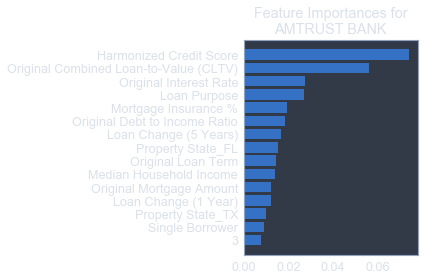

None
BANK OF AMERICA, N.A.


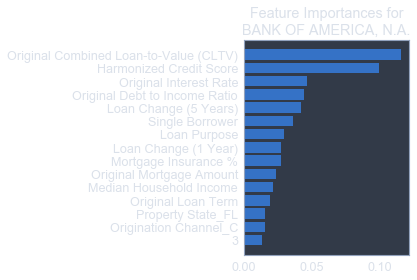

None
CHASE HOME FINANCE


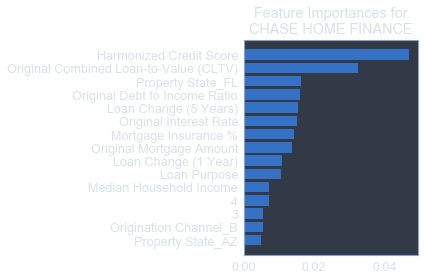

None
CITIMORTGAGE, INC.


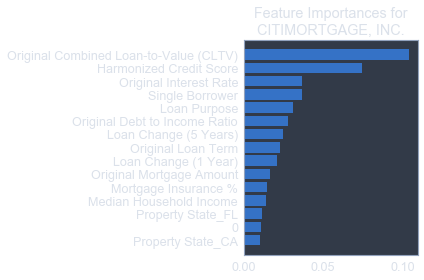

None
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB


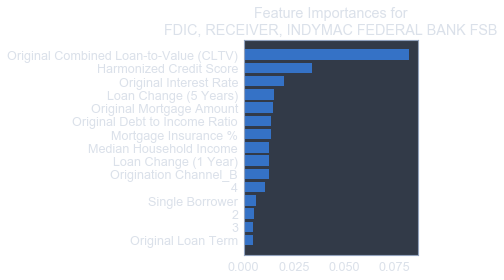

None
FIRST TENNESSEE BANK NATIONAL ASSOCIATION


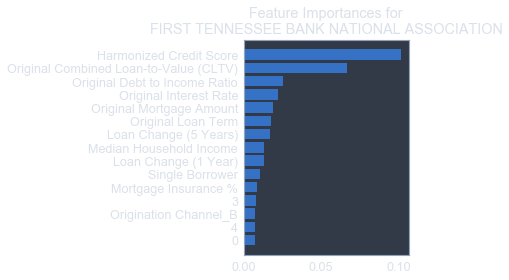

None
FLAGSTAR CAPITAL MARKETS CORPORATION


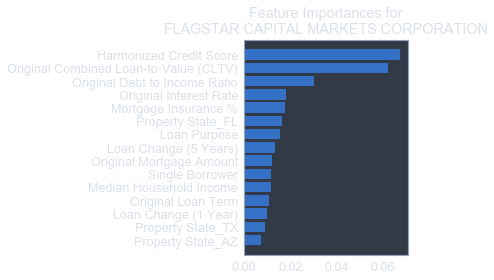

None
GMAC MORTGAGE


ValueError: Input contains infinity or a value too large for dtype('float64').

In [54]:
# Relative importance for balanced classes
rel_imp_bal = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    rel_imp_bal[bank_str] = relative_importance(Banks_X[bank_str], Banks_y[bank_str], 
                                                bank_str = bank_str, method='bal')
    
# Save final dictionary
file_to_store = open("rel_imp_bal.pickle", "wb")
pickle.dump(rel_imp_bal, file_to_store)
file_to_store.close()

AMTRUST BANK


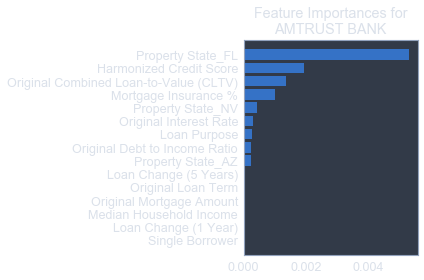

None
BANK OF AMERICA, N.A.


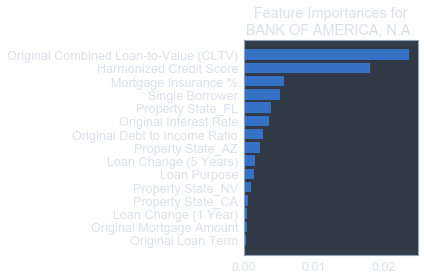

None
CHASE HOME FINANCE


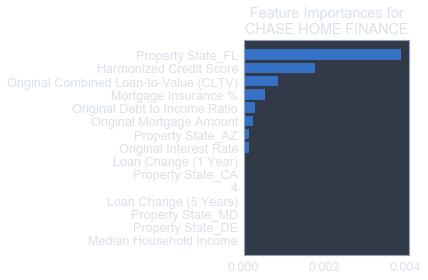

None
CITIMORTGAGE, INC.


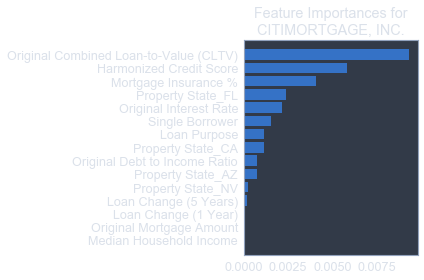

None
FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB


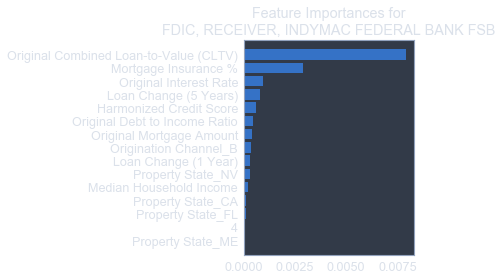

None
FIRST TENNESSEE BANK NATIONAL ASSOCIATION


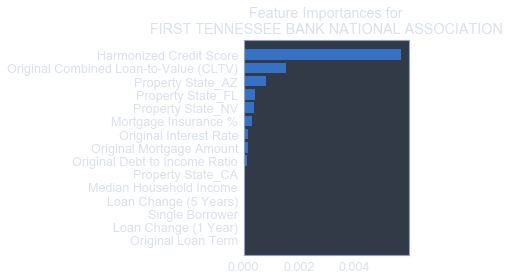

None
FLAGSTAR CAPITAL MARKETS CORPORATION


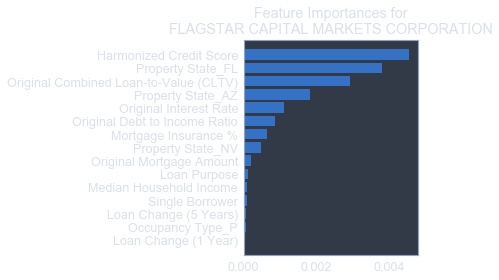

None
GMAC MORTGAGE


ValueError: Input contains infinity or a value too large for dtype('float64').

In [57]:
# Relative importance for weighted classes
rel_imp_wgt = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    rel_imp_bal[bank_str] = relative_importance(Banks_X[bank_str], Banks_y[bank_str], 
                                                bank_str = bank_str, method='wgt')
    
# Save final dictionary
file_to_store = open("rel_imp_wgt.pickle", "wb")
pickle.dump(rel_imp_wgt, file_to_store)
file_to_store.close()

AMTRUST BANK


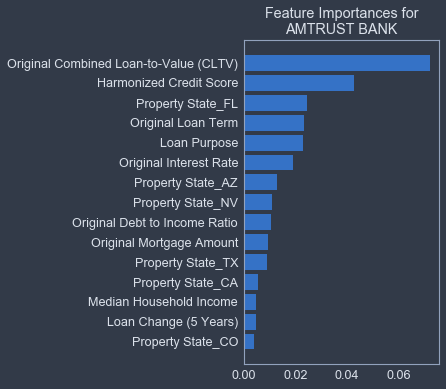

None
BANK OF AMERICA, N.A.


In [ ]:
# Relative importance for unbalanced classes
rel_imp_unbal = {}
for bank_str in np.unique(df['Bank']):
    print(bank_str)
    rel_imp_unbal[bank_str] = relative_importance(Banks_X[bank_str], Banks_y[bank_str], 
                                                  bank_str = bank_str, method='eec')
    
# Save final dictionary
file_to_store = open("rel_imp_unbal.pickle", "wb")
pickle.dump(rel_imp_unbal, file_to_store)
file_to_store.close()

***